In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.layers import SimpleRNN, Dense, Activation

top_words = 10000
(X_train, y_train), (X_test, y_test) = imdb.load_data(nb_words=top_words)         

17465344/17464789 [==============================] - 0s 0us/step


In [3]:
print("Type: ", type(X_train))
print("Type: ", type(y_train))

Type:  <class 'numpy.ndarray'>
Type:  <class 'numpy.ndarray'>


In [4]:
print("X train shape: ",X_train.shape)
print("Y train shape: ",y_train.shape)
print("X train shape: ",X_test.shape)
print("Y train shape: ",y_test.shape)

X train shape:  (25000,)
Y train shape:  (25000,)
X train shape:  (25000,)
Y train shape:  (25000,)


Y train values:  [0 1]
Y test values:  [0 1]
Y train distribution:  {0: 12500, 1: 12500}
Y testdistribution:  {0: 12500, 1: 12500}
[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 

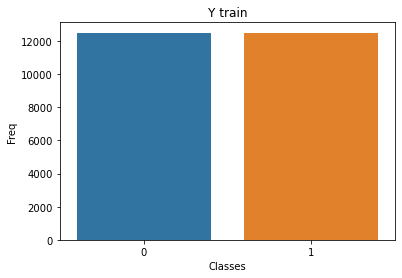

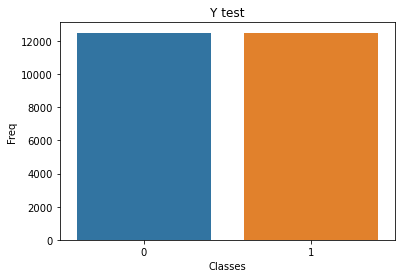

In [5]:
# %% EDA
print("Y train values: ",np.unique(y_train))
print("Y test values: ",np.unique(y_test))

unique, counts = np.unique(y_train, return_counts = True)
print("Y train distribution: ",dict(zip(unique,counts)))

unique, counts = np.unique(y_test, return_counts = True)
print("Y testdistribution: ",dict(zip(unique,counts)))

plt.figure()
sns.countplot(y_train)
plt.xlabel("Classes")
plt.ylabel("Freq")
plt.title("Y train")

plt.figure()
sns.countplot(y_test)
plt.xlabel("Classes")
plt.ylabel("Freq")
plt.title("Y test")

d = X_train[0]
print(d)
print(len(d))

review_len_train = []
review_len_test = []
for i, ii in zip(X_train, X_test):
    review_len_train.append(len(i))
    review_len_test.append(len(ii))

Train mean: 238.71364
Train median: 178.0
Train mode: ModeResult(mode=array([132]), count=array([196]))


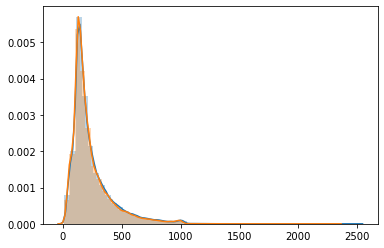

In [6]:
# kelime dağılımlarına bakıyoruz
sns.distplot(review_len_train, hist_kws = {"alpha":0.3})
sns.distplot(review_len_test, hist_kws = {"alpha":0.3})

print("Train mean:", np.mean(review_len_train))
print("Train median:", np.median(review_len_train))
print("Train mode:", stats.mode(review_len_train))

In [7]:
# %% Preprocess

num_words = 10240 #15000
(X_train, Y_train), (X_test, Y_test) = imdb.load_data(num_words=num_words)

maxlen = 32 #130
X_train = pad_sequences(X_train, maxlen=maxlen)
X_test = pad_sequences(X_test, maxlen=maxlen)

print(X_train[5])

for i in X_train[0:10]:
    print(len(i))


[1051    2   32   85  156   45   40  148  139  121  664  665   10   10
 1361  173    4  749    2   16 3804    8    4  226   65   12   43  127
   24    2   10   10]
32
32
32
32
32
32
32
32
32
32


In [8]:
# %% RNN

rnn = Sequential()
rnn.add(Embedding(num_words, 16, input_length = (maxlen))) #32
rnn.add(SimpleRNN(16, input_shape = (num_words,maxlen), return_sequences= False, activation= "tanh"))
rnn.add(Dense(1))
rnn.add(Activation("sigmoid"))

print(rnn.summary())
rnn.compile(loss = "binary_crossentropy", optimizer="adam",metrics= ["accuracy"]) #rmsprop
history = rnn.fit(X_train, Y_train, validation_data= (X_test, Y_test), epochs=10, batch_size= 128, verbose=1)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 32, 16)            163840    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 16)                528       
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
_________________________________________________________________
activation (Activation)      (None, 1)                 0         
Total params: 164,385
Trainable params: 164,385
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
196/196 [==============================] - 2s 13ms/step - loss: 0.6022 - accuracy: 0.6604 - val_loss: 0.4852 - val_accuracy: 0.7697
Epoch 2/10
196/196 [==============================] - 2s 11ms/step - loss: 0.3993 - accuracy: 0.8252

Accuracy: % 99.95999932289124


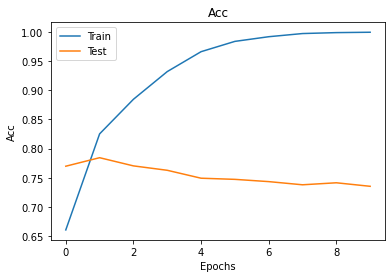

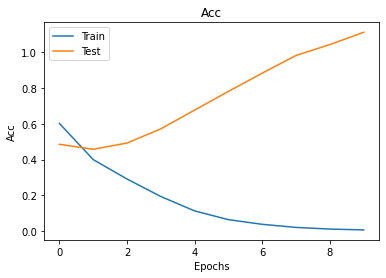

In [9]:

print("Accuracy: %",history.history["accuracy"][-1]*100)

plt.figure()
plt.plot(history.history["accuracy"], label = "Train")
plt.plot(history.history["val_accuracy"], label = "Test")
plt.title("Acc")
plt.ylabel("Acc")
plt.xlabel("Epochs")
plt.legend()
plt.show()

plt.figure()
plt.plot(history.history["loss"], label = "Train")
plt.plot(history.history["val_loss"], label = "Test")
plt.title("Acc")
plt.ylabel("Acc")
plt.xlabel("Epochs")
plt.legend()
plt.show()
